In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

%matplotlib inline

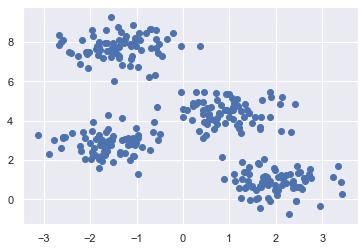

In [2]:
from sklearn.datasets import make_blobs

# Generation spherical groups
X, y = make_blobs(n_samples=300, # Size of generated sample
                  centers=4,     # Number of clusters
                  cluster_std=0.60, random_state=0)

plt.scatter(X[:,0], X[:,1])

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X) # Cluster labels for each records

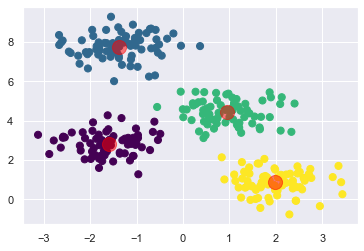

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)

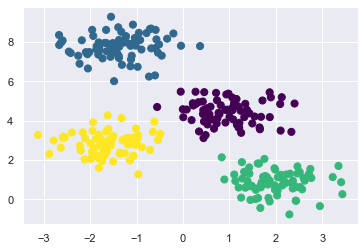

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

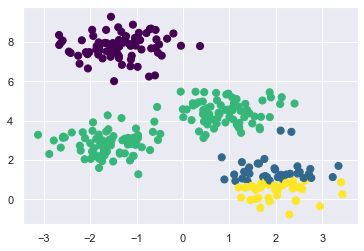

In [6]:
# What happend if we don't shape the sample?

centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

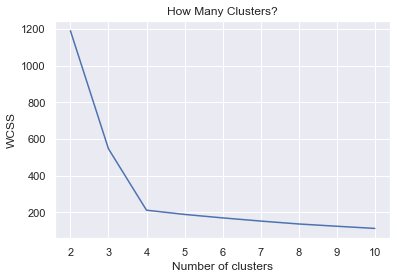

In [7]:
wcss = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, 
                    n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss)
plt.title('How Many Clusters?')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

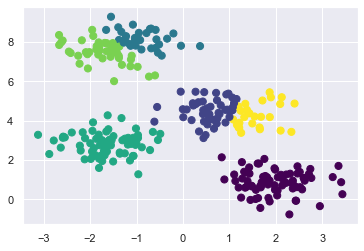

In [8]:
# Clustering on 6 clusters

labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

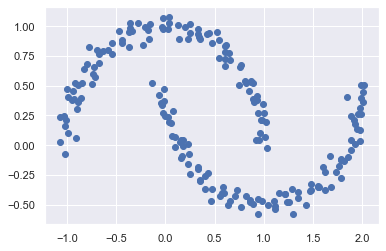

In [9]:
from sklearn.datasets import make_moons

#Generation moon-like groups
X, y = make_moons(200, noise=.05, random_state=0)

plt.scatter(X[:,0], X[:,1])

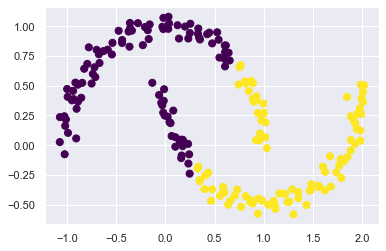

In [10]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

C:\Users\vira.liubchenko\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


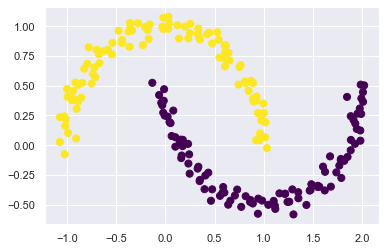

In [11]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', 
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

In [12]:
import pandas as pd

data = pd.read_csv('data/10-mall_customers.csv')
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


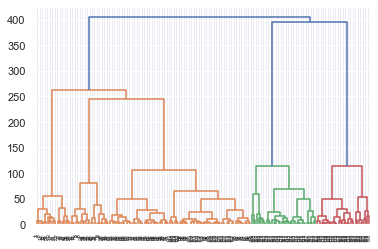

In [13]:
import scipy.cluster.hierarchy as sch

X = data.iloc[:, [3, 4]].values
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

In [14]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model.fit(X)
labels = model.labels_

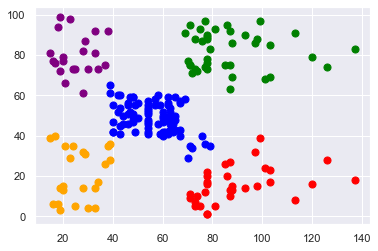

In [15]:
plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
plt.scatter(X[labels==3, 0], X[labels==3, 1], s=50, marker='o', color='purple')
plt.scatter(X[labels==4, 0], X[labels==4, 1], s=50, marker='o', color='orange')
plt.show()

## Mulitivariate Outliers

In [16]:
df_out = pd.read_csv("data/05-insurance.csv")
df_out.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [17]:
from sklearn.cluster import DBSCAN

X = df_out[['age','bmi']].values

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_

In [18]:
pd.Series(labels).value_counts()

 0    1312
-1      26
dtype: int64

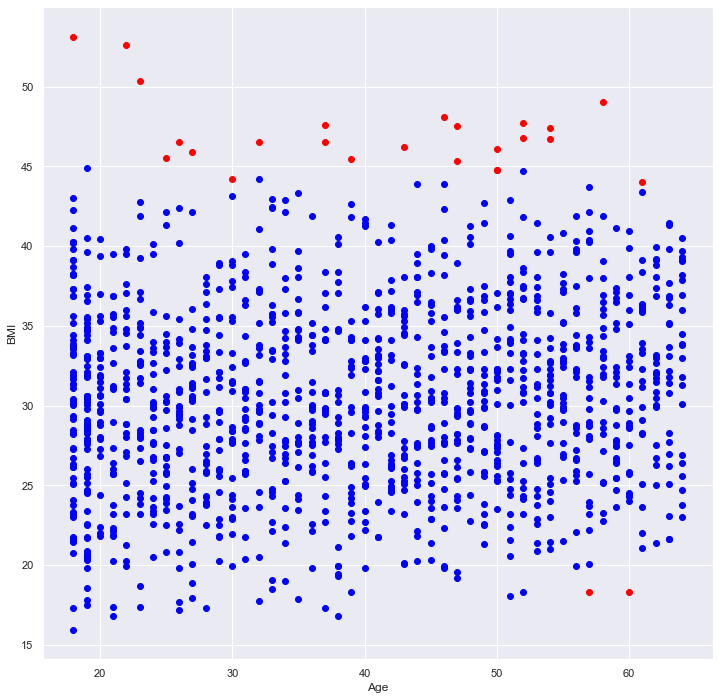

In [19]:
plt.figure(figsize=(12,12))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel('Age');
plt.ylabel('BMI');

### Local Outlier Factor Method (LOF)

In [20]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')

X = df_out[['age','bmi']].values
y_pred = clf.fit_predict(X)

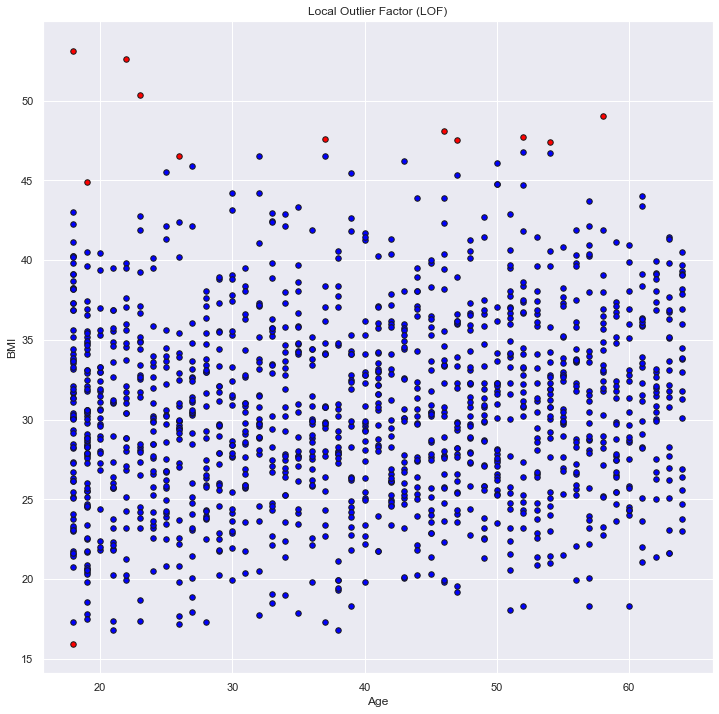

In [21]:
plt.figure(figsize=(12,12))
# plot the level sets of the decision function

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
plt.xlabel('Age');
plt.ylabel('BMI');

plt.show()